In [23]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import time 
import numpy as np

In [4]:
# %%cython
#透過距離計算用プログラム
#x軸に沿ったスリットの平行移動を考える
def light_receiving_t_d(gradient , intercept, x_k, y_k, distance1, distance2, slit1, slit2, r_d, transmittance):
    
    #スリットの位置の定義
    #配列制作用
    const = r_d
    i = 0
    test_x = []
    test_y = []
    
    x1y1 = [[0 for i in range(2)] for i in range(const*2 +1)]
#     x1y1 = np.zeros((const*2 +1,2))
    x2y2 = [[0 for i in range(2)] for i in range(const*2 +1)]
#     x2y2 = np.zeros((const*2 +1,2))
    #とりあえず外径の　1.5倍外
    
    #ここおかしくね？？？？
    for d in [tmp*0.1 for tmp in range(-const, const+1)]:
        x1 = d
        y1 = -distance1
        x2 = d
        y2 = -distance2
        x1y1[i][0] = x1
        x1y1[i][1] = y1
        x2y2[i][0] = x2
        x2y2[i][1] = y2
        i += 1 
        test_x.append(x1)
        test_y.append(y1)


    count_light = [0] * (const *2 + 1)
    
    cnt_slit1 = 0
    cnt_slit2 = 0
    
    count_x = []
    count_y = []
    
    #透過距離
    distance_t = [i for i in range(const * 2 + 1)]
#     distance_t = np.arange(const * 2 + 1)
    #ここのとり方を変える
    #zip使うと遅くなる？→普通のforループに書き直しても良いかも
    for g, i, xk, yk, tm in zip(gradient, intercept, x_k, y_k, transmittance):
        if yk == 0:
            continue
        for j in range(-const, const +1): #-x,xで動かす
            #スリットと,光線の交点
            a = 0
            b = x1y1[j][1]
            x = (i - b)/(a - g)
            #スリット幅(斜めver)
            s_d = slit1/2
            #1つ目のスリットを超えられるかどうか
            ##この条件がおかしそう
            if x < x1y1[j][0] + s_d and x1y1[j][0] - s_d < x:
                #2つめの条件に変更
                #ここの計算間違っている説あり（要確認)
                b = x2y2[j][1]
                x = (i - b)/(a - g)
                s_d = slit2/2
                cnt_slit1 += 1
                #2つ目のスリットを超えられるかどうか
                if x < x2y2[j][0] + s_d and x2y2[j][0] - s_d < x:
                    cnt_slit2 += 1
                    #光の本数をカウント
                    count_light[j] += tm
                    count_x.append(x)
                    y = g*x + i
                    count_y.append(y)
                    
                    
    return count_light, distance_t, count_x, count_y, test_x, test_y
                    

In [9]:
#透過角 を求めるための回転装置をもしたシミュレーション
#90度だけで良さそう
#全ての直線データをぶちこむ
#外周座標は最後の透過角を求めるために必要。
# import time
# %%cython
#回転中心が違うぽい
def light_receiving_t_a(gradient ,intercept, x_k, y_k, distance1, distance2, slit1, slit2, center_x, center_y, transmittance):
    #print("値が入ってるか？",gradient[0],intercept[0],x_k[0],y_k[0],distance1,distance2)
#     t1 = time.time() 
    
    #まずslitの位置を定義 下準備
    #円管とスリットの距離の定義が必要
#     distance1 = 1
#     distance2 = 1
    i = 0
    test_x = []
    test_y = []
    
    x1y1 = np.zeros((900,2))
    x2y2 = np.zeros((900,2))
    s_sita = np.zeros(1801)
    for sita in [tmp*0.1 for tmp in range(1800, 2700)]:
        x1 = distance1*np.cos(np.deg2rad(sita)) + center_x
        y1 = distance1*np.sin(np.deg2rad(sita)) + center_y
        x2 = distance2*np.cos(np.deg2rad(sita)) + center_x
        y2 = distance2*np.sin(np.deg2rad(sita)) + center_y
        similar_sita = abs(np.arctan(np.tan(abs(x1)/abs(y1))))
        x1y1[i][0] = x1
        x1y1[i][1] = y1
        x2y2[i][0] = x2
        x2y2[i][1] = y2
        s_sita[i] = similar_sita
        i += 1
        test_x.append(x1)
        test_y.append(y1)
        
    # 経過時間を表示
#     t2 = time.time()
#     elapsed_time_1 = t2-t1
#     print(f"経過時間：{elapsed_time_1}","秒")
#     print("---------------下準備終了！------------------")
    
#     t3 = time.time() 
    #スリット幅を入力
    #need to change
#     slit1 = 1
#     slit2 = 1
    #ある角度における光線の本数カウント用
    count_light = [0] * 900
    count_x = [0] * 900
    count_y = [0] * 900
#     t_angle = [0] * 900
    t_angle = [0] * 900
    
    cnt_slit1 = 0
    cnt_slit2 = 0
    count_x = []
    count_y = []
    
    for g, i, xk, yk, tm in zip(gradient, intercept, x_k, y_k, transmittance):
        if yk == 0:
            continue
        for j in range(900): #90度分の回転を表す
            #スリットの傾きと,光線の交点
            a = -np.tan(s_sita[j])
            b = x1y1[j][1] - a*x1y1[j][0]
            x = (i - b)/(a - g)
            #スリット幅(斜めver)
            s_d = slit1*np.cos(abs(s_sita[j]))/2
            #1つ目のスリットを超えられるかどうか
            if x < x1y1[j][0] + s_d and x1y1[j][0] - s_d < x:
                #2つめの条件に変更
                b = x2y2[j][1] - a*x2y2[j][0]
                x = (i - b)/(a - g)
                s_d = slit2*np.cos(abs(s_sita[j]))/2
                cnt_slit1 += 1
                #2つ目のスリットを超えられるかどうか
                if x < x2y2[j][0] + s_d and x2y2[j][0] - s_d < x:
                    cnt_slit2 += 1
                    #光の本数をカウント
                    count_light[j] += tm
#                     #透過角算出用のx,yもおいておきたい→平均orとりあえずmin,maxの2つをキープしておいて考える。
#                     #怪しい、場合によってはmaxminが大幅に離れてる？→ここはどのへんに値が偏っているのかを見てもいいかも一旦保留
                    
#                     ##ここで透過角を計算する
#                     count_x[j] += xk
#                     count_y[j] += yk
                    #ここで透過角を入れていけば良いんじゃないだろうか？
#                     x_slit2 = x2y2[j][0]
#                     y_slit2 = x2y2[j][1]
                    count_x.append(x)
                    y = g*x + i
                    count_y.append(y)
                    a = y - yk
                    b = xk - x
                    c = 1
                    d = 0
                    t_angle[j] = np.rad2deg(np.arctan(np.tan(abs(a*d - b*c)/abs(a*c + b*d))))
    
    # 経過時間を表示
#     t4 = time.time()
#     elapsed_time_2 = t4-t3
#     print(f"経過時間：{elapsed_time_2}","秒")
#     print("---------------光線の処理完了！------------------")
#     print("スリット1枚目を超えられた本数",cnt_slit1)
#     print("スリット2枚目を超えられた本数",cnt_slit2)
    #print("光線の本数は？",sum(count_light))
    
#     t5 = time.time()
    #jごとの透過角を求める必要がある(横軸)
#     for j in range(900):
#         #ある角度jのときのスリットを透過する外周の点の平均
#         if count_light[j] == 0:
#             continue
#         x_g = count_x[j]/count_light[j]
#         y_g = count_y[j]/count_light[j]
#         x_slit2 = x2y2[j][0]
#         y_slit2 = x2y2[j][1]
#         a = y_slit2 - y_g
#         b = x_g - x_slit2
#         c = 1
#         d = 0
#         t_angle[j] = np.rad2deg(np.arctan(np.tan(abs(a*d - b*c)/abs(a*c + b*d))))
        
    # 経過時間を表示
#     t6 = time.time()
#     elapsed_time_3 = t6-t5
#     print(f"経過時間：{elapsed_time_3}","秒")
#     print("---------------透過角算出！------------------")
    
#     print("総実行時間:",(elapsed_time_1+elapsed_time_2+elapsed_time_3)/60,"分")
    
    
    return count_light, t_angle, count_x, count_y, test_x, test_y

データ読み込み数: 18748
経過時間： 0.00033244689305623375 分
---------------下準備終了！------------------
透過角算出!
経過時間： 1.4144079089164734 分
---------------------------------
経過時間： 2.718283732732137 分
---------------------------------


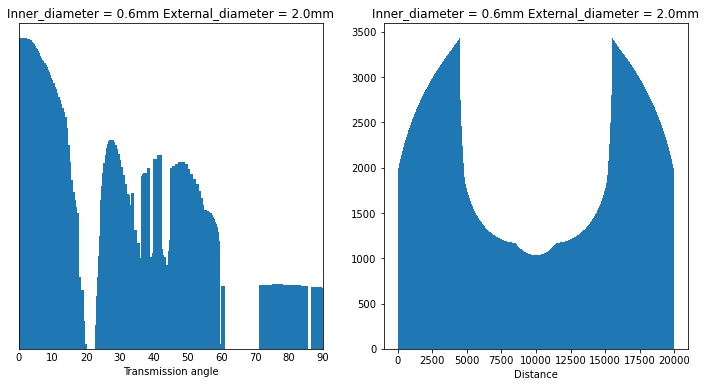

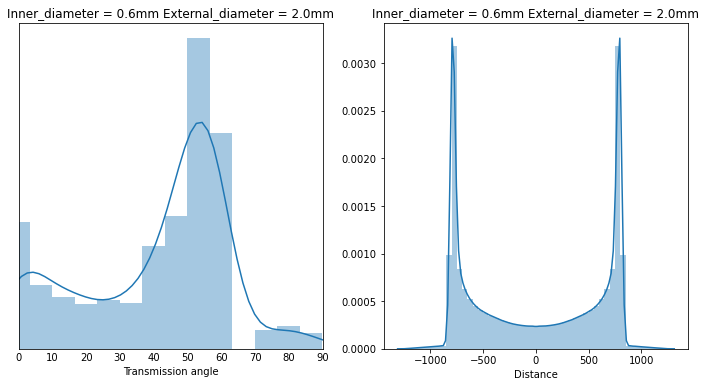

In [27]:
#テスト用
# %%cython
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import time 
import numpy as np
import seaborn as sns
#need to change

r = 10000
r_i = 3000
r_i = round(r_i)
#1mm → 10000  0.2mm → 2000 0.05mm → 500
#円管とスリットの距離

h1 = 1000
h2 = 1000
d1 = r + h1
d2 = d1 + h2
#スリット幅
s1 = 2000
s2 = 500
t1 = time.time() 
#複数のCSVファイルを順次読み込んでグラフを表示していく
df = pd.read_csv('./data_csv3/dataset_r_i_{0}_r_{1}.csv'.format(r_i, r))
new_x_a_list = df['x'] 
new_y_a_list = df['y']
gradient_list = df['gradient']
intercept_list = df['intercept']
center_x_list = df['change_x']
center_y_list = df['change_y']
transmittance_list = df['transmittance']

print("データ読み込み数:",len(new_x_a_list))

t2 = time.time()
elapsed_time_1 = t2-t1
print("経過時間：",elapsed_time_1/60,"分")
print("---------------下準備終了！------------------")
t3 = time.time() 
light_num_a, toka_angle,light_x1,light_y1,debug_x1,debug_y1 = light_receiving_t_a(gradient_list ,intercept_list, new_x_a_list, new_y_a_list, d1, d2,s1 ,s2, center_x_list[0], center_y_list[0], transmittance_list)
print("透過角算出!")
t4 = time.time()
elapsed_time_2 = t4-t3
print("経過時間：",elapsed_time_2/60,"分")
print("---------------------------------")
d1 = r + h1
d2 = d1 + h2
t5 = time.time() 
light_num_d, distance,light_x,light_y,debug_x2,debug_y2 = light_receiving_t_d(gradient_list ,intercept_list, new_x_a_list, new_y_a_list, d1, d2,s1 ,s2, r, transmittance_list)
t6 = time.time()
elapsed_time_3 = t6-t5
print("経過時間：",elapsed_time_3/60,"分")
print("---------------------------------")
fig = plt.figure(figsize=(12,6))
#         fig.subplots_adjust(wspace=0.5)
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
ax1.set_xlim([0,90])
ax1.bar(toka_angle, light_num_a, width=1.0)
ax2.bar(distance, light_num_d, width=1.0)
ax1.set_title('Inner_diameter = {0}mm External_diameter = {1}mm'.format(r_i*2/10000, r*2/10000))
ax2.set_title('Inner_diameter = {0}mm External_diameter = {1}mm'.format(r_i*2/10000, r*2/10000))
ax1.set_xlabel('Transmission angle')
ax2.set_xlabel('Distance')
ax1.set_yticklabels([])
#         ax2.set_yticklabels([])
ax1.tick_params(length=0)
#         ax2.tick_params(length=0)
#plt.show()
fig.savefig('./figure_data/cnt_figure_d1_{0}_d2_{1}.png'.format(d1, d2))

fig2 = plt.figure(figsize=(12,6))
#         fig.subplots_adjust(wspace=0.5)
ax3 = fig2.add_subplot(1, 2, 1)
ax4 = fig2.add_subplot(1, 2, 2)
sns.distplot(toka_angle, ax = ax3)
sns.distplot(light_x, ax = ax4)
ax3.set_xlim([0,90])
ax3.set_title('Inner_diameter = {0}mm External_diameter = {1}mm'.format(r_i*2/10000, r*2/10000))
ax4.set_title('Inner_diameter = {0}mm External_diameter = {1}mm'.format(r_i*2/10000, r*2/10000))
ax3.set_xlabel('Transmission angle')
ax4.set_xlabel('Distance')
ax3.set_yticklabels([])
#         ax2.set_yticklabels([])
ax3.tick_params(length=0)
#         ax2.tick_params(length=0)
#plt.show()
fig2.savefig('./figure_hist/figure_d1_{0}_d2_{1}.png'.format(d1, d2))




rの変位域-10000<=r<=10000
取得したxの数 40423306


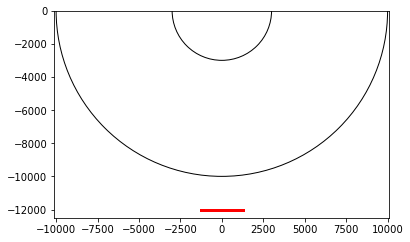

In [28]:
#座標確認

import matplotlib.pyplot as plt
import matplotlib.patches as patches

g = plt.subplot()
#外径
draw_circle_r = plt.Circle((0, 0), r, fill=False)
#内径
draw_circle_i = plt.Circle((0, 0), r_i, fill=False)
g.add_artist(draw_circle_r)
g.add_artist(draw_circle_i)
g.plot(light_x, light_y, marker="o", color = "red", linestyle = " ",markersize=1)

g.set_aspect('equal')
g.set_xlim([-r-100,r+100])
g.set_ylim([-12500,0])

print("rの変位域{0}<=r<={1}".format(-r,r))
print("取得したxの数",len(light_x))



NameError: name 'r' is not defined

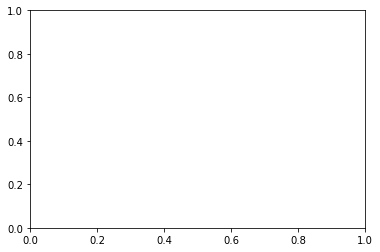

In [1]:
#座標確認

import matplotlib.pyplot as plt
import matplotlib.patches as patches

g = plt.subplot()
#外径
draw_circle_r = plt.Circle((0, 0), r, fill=False)
#内径
draw_circle_i = plt.Circle((0, 0), r_i, fill=False)
g.add_artist(draw_circle_r)
g.add_artist(draw_circle_i)
g.plot(light_x1, light_y1, marker="o", color = "red", linestyle = " ",markersize=1)

g.set_aspect('equal')
g.set_xlim([-r-10000,r+10000])
g.set_ylim([-25000,12500])

print("rの変位域{0}<=r<={1}".format(-r,r))
print("取得したxの数",len(light_x1))

rの変位域-10000<=r<=10000
取得したxの数 208718


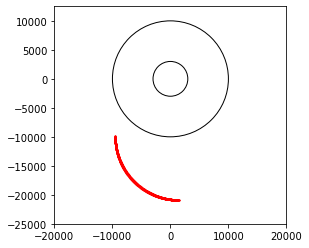

In [12]:
#座標確認

import matplotlib.pyplot as plt
import matplotlib.patches as patches

g = plt.subplot()
#外径
draw_circle_r = plt.Circle((0, 0), r, fill=False)
#内径
draw_circle_i = plt.Circle((0, 0), r_i, fill=False)
g.add_artist(draw_circle_r)
g.add_artist(draw_circle_i)
g.plot(debug_x1, debug_y1, marker="o", color = "red", linestyle = " ",markersize=1)

g.set_aspect('equal')
g.set_xlim([-r-10000,r+10000])
g.set_ylim([-25000,12500])

print("rの変位域{0}<=r<={1}".format(-r,r))
print("取得したxの数",len(light_x1))

In [ ]:
#座標確認

import matplotlib.pyplot as plt
import matplotlib.patches as patches

g = plt.subplot()
#外径
draw_circle_r = plt.Circle((0, 0), r, fill=False)
#内径
draw_circle_i = plt.Circle((0, 0), r_i, fill=False)
g.add_artist(draw_circle_r)
g.add_artist(draw_circle_i)
g.plot(debug_x2, debug_y2, marker="o", color = "red", linestyle = " ",markersize=1)

g.set_aspect('equal')
g.set_xlim([-r-10000,r+10000])
g.set_ylim([-25000,12500])

print("rの変位域{0}<=r<={1}".format(-r,r))
print("取得したxの数",len(light_x1))